N_trunc =  2


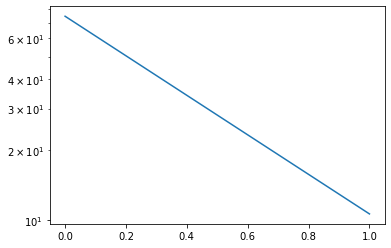

In [2]:
import sys
import numpy as np
sys.path.append('../../../nn')

# import mynn
from mynn import *

N_θ = 100

prefix = "../"
θ = np.load(prefix+"Random_Helmholtz_theta_" + str(N_θ) + ".npy")   
κ = np.load(prefix+"Random_Helmholtz_K_" + str(N_θ) + ".npy")

θ_train, κ_train = θ[0::2, :], κ[:, :,  0::2]
θ_test, κ_test = θ[1::2, :], κ[:, :,  1::2]


# Scale the training data
coeff_scale = 100.0


data_svd, bases, N_trunc, s = build_bases(κ_train, acc=0.99)
plt.semilogy(s)

x_train = torch.from_numpy(θ_train.astype(np.float32))
y_train = torch.from_numpy(data_svd.astype(np.float32)*coeff_scale)

In [3]:
# TODO change to DirectNet_50
N_neurons = 20

if N_neurons == 20:
    DirectNet = DirectNet_20
elif N_neurons == 50:
    DirectNet = DirectNet_50

model = DirectNet(N_θ, N_trunc)
# model = torch.load("PCANet_"+str(N_neurons)+".model")

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_scale = 1000
n_epochs = 50000
for epoch in range(n_epochs):
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train) * loss_scale

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "PCANet_"+str(N_neurons)+".model")

	
# save the model
torch.save(model, "PCANet_"+str(N_neurons)+".model")

[0/500000], loss: 31195888.0
[10000/500000], loss: 0.0
[20000/500000], loss: 189.265
[30000/500000], loss: 0.083
[40000/500000], loss: 0.001
[50000/500000], loss: 0.0
[60000/500000], loss: 0.0
[70000/500000], loss: 31.917
[80000/500000], loss: 20.226


KeyboardInterrupt: 

## Training error 

Averaged training error is  1.347672320490113e-05


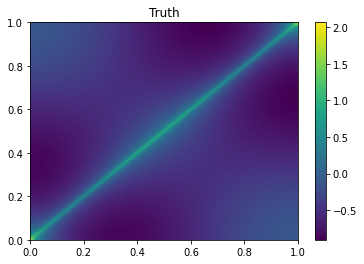

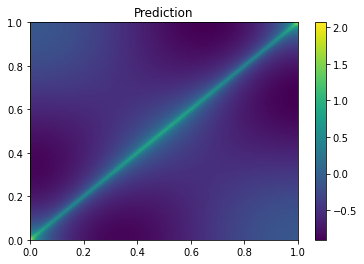

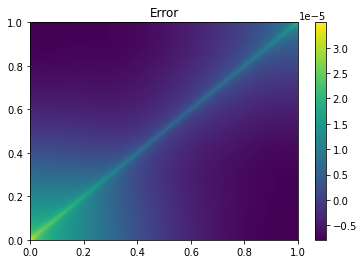

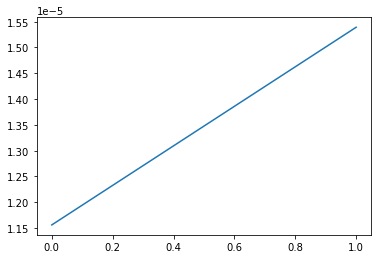

In [4]:
######################################################
N_data, N_θ  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

κ_pred = model(torch.from_numpy(θ_train.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

train_ids = np.arange(0, N_data)
errors = np.zeros(len(train_ids))

plot_freq = 249
for train_id in train_ids:

    errors[train_id] =  np.linalg.norm(κs_pred[:, :, train_id] - κ_train[:, :, train_id])/np.linalg.norm(κ_train[:, :, train_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if train_id % plot_freq == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_train[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % train_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % train_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id] - κ_train[:, :, train_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Averaged training error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)



## Test error 

Averaged test error is  0.8828291956793257


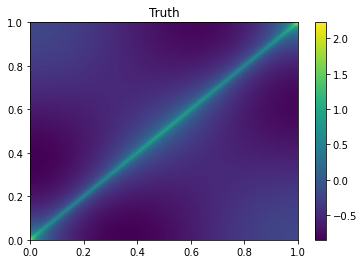

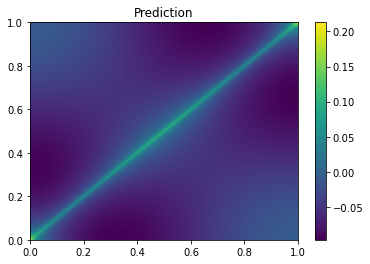

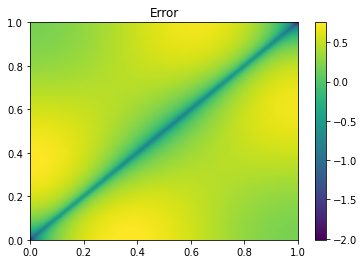

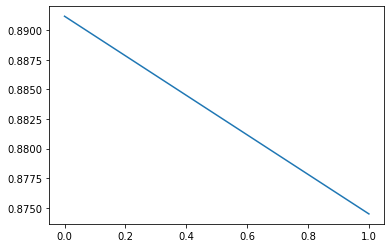

In [5]:
N_data, N_θ  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

κ_pred = model(torch.from_numpy(θ_test.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

test_ids = np.arange(0, N_data)
errors = np.zeros(len(test_ids))

plot_freq = 249

for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κs_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id % plot_freq == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id] - κ_test[:, :, test_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Averaged test error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)


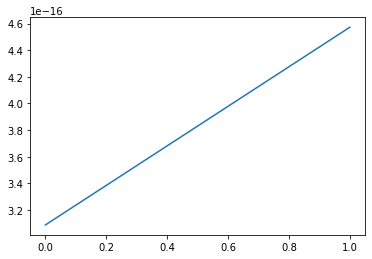

In [6]:
κs = κ_train

# Test projection error on the training set
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)

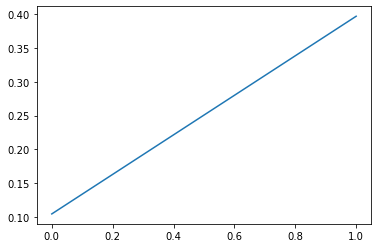

In [7]:
κs = κ_test

# Test projection error on the test set
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)
